In [1]:
import argparse
import io
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
# Reading in the qPCR csv
df = pd.read_csv("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Viability_analysis/2024_12_17_BM_OS384_NFE2L3_NR0B2024_12_17_BM_OS384_NFE2L3_qPCR.csv")

df["rep"] = df.groupby(["Target", "Sample"]).cumcount()

In [4]:
GOI          = "NFE2L3"       
HOUSEKEEPING = "GAPDH"        
CONTROL      = "NTCTRL"  


hk  = df[df["Target"] == HOUSEKEEPING][["Sample", "rep", "Cq"]].rename(columns={"Cq": "Ct_HK"})
goi = df[df["Target"] == GOI][["Sample", "rep", "Cq"]].rename(columns={"Cq": "Ct_GOI"})

In [6]:
merged = pd.merge(goi, hk, on=["Sample", "rep"], how="left")

merged["Ct_HK"] = merged.groupby("Sample")["Ct_HK"].transform(lambda x: x.fillna(x.mean()))


In [8]:
#ΔCt (normalise to housekeeping for every replicate)
merged["ΔCt"] = merged["Ct_GOI"] - merged["Ct_HK"]

In [9]:
#pair control and test replicates by 'rep', then ΔΔCt and 2^-ΔΔCt
ctrl_dct = merged[merged["Sample"] == CONTROL][["rep", "ΔCt"]].rename(columns={"ΔCt": "ΔCt_control"})
test_dct = merged[merged["Sample"] != CONTROL][["Sample", "rep", "ΔCt"]]

In [10]:
paired = pd.merge(test_dct, ctrl_dct, on="rep")
paired["ΔΔCt"]      = paired["ΔCt"] - paired["ΔCt_control"]
paired["fold_change"] = 2 ** (-paired["ΔΔCt"])

In [11]:
summary = paired.groupby("Sample")["fold_change"].agg(["mean", "std", "count"])
summary["sem"] = summary["std"] / np.sqrt(summary["count"])

In [13]:

    
samples = [CONTROL] + list(summary.index)      
means   = [1]       + list(summary["mean"])
errors  = [0]       + list(summary["sem"])

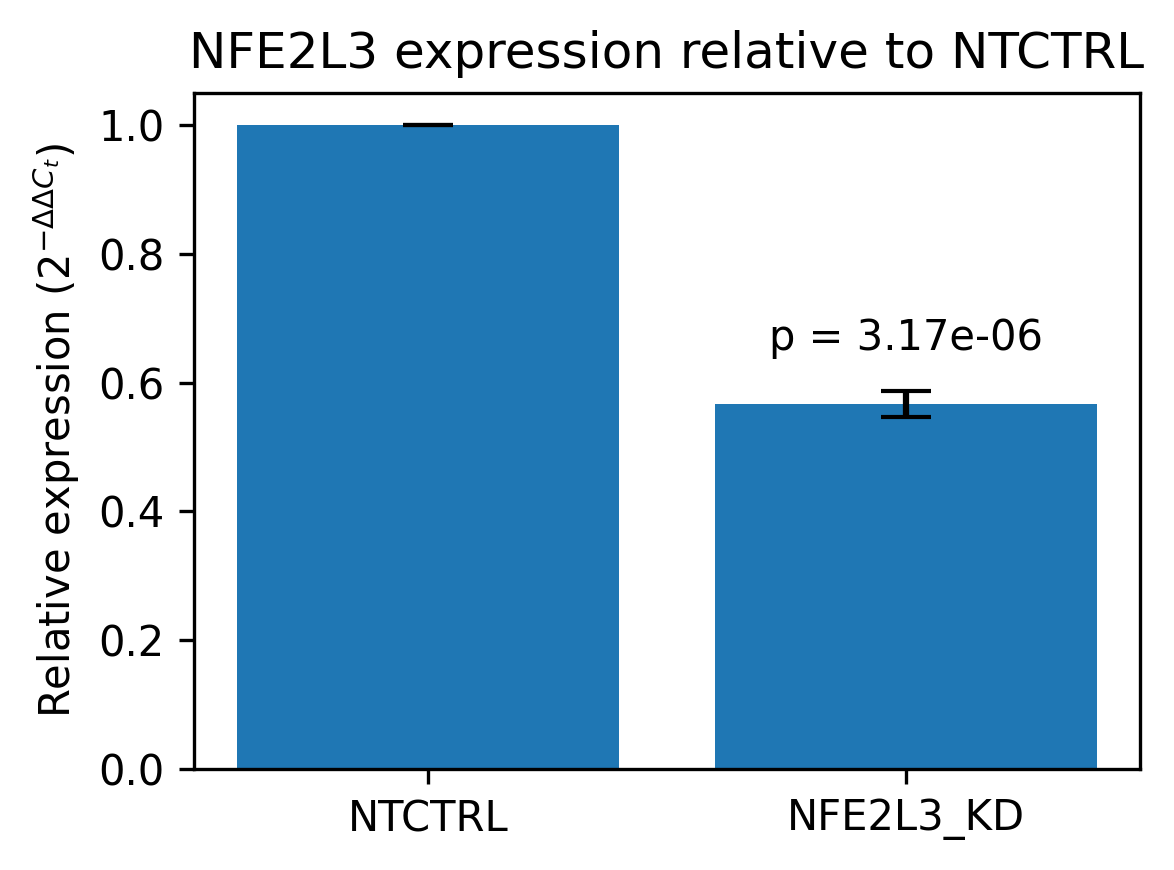

In [15]:
fig, ax = plt.subplots(figsize=(4.0, 3), dpi=300)

x = np.arange(len(samples))
bars = ax.bar(x, means, yerr=errors, capsize=6, zorder=2)
ax.set_xticks(x, samples)
ax.set_ylabel("Relative expression (2$^{-\\Delta\\Delta C_t}$)")
ax.set_title(f"{GOI} expression relative to {CONTROL}")


for idx, sample in enumerate(samples):
    if sample == CONTROL:
        continue  

    # Welch t-test on ΔCt values
    t_stat, p_val = stats.ttest_ind(
        merged.loc[merged["Sample"] == sample,  "ΔCt"],
        merged.loc[merged["Sample"] == CONTROL, "ΔCt"],
        equal_var=False,
    )

    # Position the text a little above the error bar
    bar_height = bars[idx].get_height()
    err_height = errors[idx] if idx < len(errors) else 0
    y_text = bar_height + err_height + 0.05  # 0.05 is a small vertical offset

    ax.text(
        x[idx], y_text, f"p = {p_val:.3g}",
        ha="center", va="bottom", fontsize=10,
    )


fig.tight_layout()
fig.savefig("/Users/brendamelano/Desktop/NFE2L3_qpcr.svg", format="svg")
plt.show()           